In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class EstimatedLandmark(Landmark):  ###fastslam5makebig
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None
        
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

        ###誤差楕円を描く###
        e = three_sigma_ellipse(self.pos, self.cov)
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle): 
    def __init__(self, weight, landmark_num):
        super().__init__(np.array([0,0,0]).T, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
    def observation_update(self, observation, distance_dev_rate, direction_dev):  ###fastslam5particleobsupdate
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            ###Hの計算###
            mx, my =  landmark.pos
            x, y, t = self.pose
            q = (mx - x)**2 + (my - y)**2
            # x,yとmx, myが近すぎると計算がおかしくなるので回避
            if q < 0.01: continue
                
            sqrtq = np.sqrt(q)
            H = np.array([[(mx - x)/sqrtq, (my - y)/sqrtq],  [(y - my)/q, (mx - x)/q]])
 
            if landmark.cov is None: 
                landmark.pos = np.array( [z[0]*math.cos(t + z[1]) + x, z[0]*math.sin(t + z[1]) + y]).T
                landmark.cov = np.array([[99,0], [0,99]])
                return
                
            ###Qの計算###
            hm = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
            distance_dev = distance_dev_rate*hm[0]
            Q = np.diag(np.array([distance_dev**2, direction_dev**2]))
            
            ###カルマンゲインの計算###
            K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
            
            ###更新###
            landmark.pos = K.dot(z - hm) + landmark.pos
            landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, landmark_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, np.array([0,0,0]).T, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):   ###fastslam5slamobsupdate
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()
        self.resampling() 
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

In [5]:
class FastSlamAgent(MclAgent): ###fastslam5agent
    def __init__(self, time_interval, nu, omega, landmark_num, particle_num=100, \
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, None, None, particle_num, motion_noise_stds)
    
        self.pf = FastSlam(particle_num, landmark_num, motion_noise_stds)

#    def decision(self, observation): #削除。MclAgentのものをそのまま使う
#        return super().decision([])

<IPython.core.display.Javascript object>


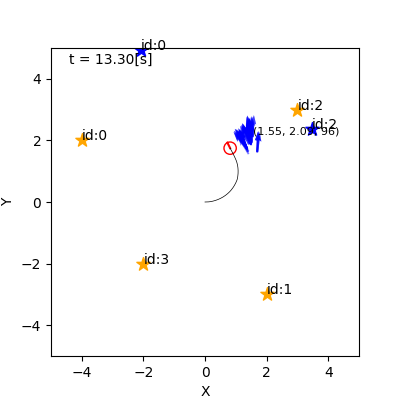

In [6]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(300, time_interval, debug=False) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3), (-2,-2)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, len(m.landmarks), particle_num=100) 
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [7]:
a.pf.ml.map.landmarks[2].cov